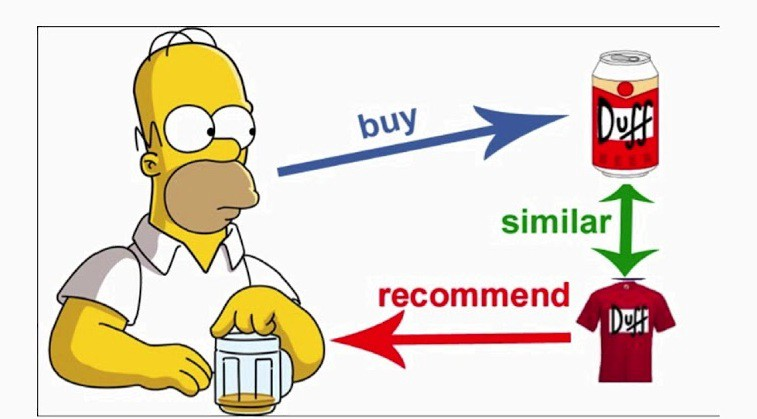

## Introduction

welcome to my notebook for [Netflix Movies and TV Shows](https://www.kaggle.com/shivamb/netflix-shows) dataset

in this kernel i will use Netflix dataset to implement my first recommendation system using Cosine Similarity and doing some visualization to understand some features, this dataset contains 7787 record and 12 column, we won't use all of them as some rows will be dropped and we will work on specific coulmns for the recommender system, hope you all like this notebook 

if you have any suggest,advice or correction please don't hesitate to write it, i think it will be very helpful for me and if you like this notebook an upvote would be great.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize 

plt.rcParams['figure.figsize'] = (13, 7)

In [ ]:
#take a look on the dataset
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")
df.head(5)

In [ ]:
#showing info for each featrue
df.info()

## Data Visualization

In [ ]:
df.head(1)

Which one is bigger? Movies or TV Shows

In [ ]:
def pie_chart(df, column ,explode , labels,title,no):
    
    plt.pie(df[column].value_counts(),
            explode=explode,    #explode=[0.04,0]
            startangle=90, 
            autopct='%1.1f%%',
            labels=labels, #labels=['Males','Females']
            colors = ['#66b3ff','#99ff99'],
            pctdistance=.6,
            textprops={'fontsize': 20})
    plt.title(title)
    plt.figure(no)

pie_chart(df, "type" ,[0.15,0.05], ['Movies',"TV series"],"Movie and TV Shows count",0)

Now let's see Top 10 directors that have more in each movies and series 

In [ ]:
Top10_movies_directors = df[df['type'] == 'Movie']

base_color = sns.color_palette()[1]

sns.countplot(y = 'director',color= base_color, data = Top10_movies_directors, order = Top10_movies_directors.director.value_counts().head(10).index)

plt.title("Top 10 Movie's Directors on Netflix", fontsize = 20);

In [ ]:
Top10_Series_directors = df[df['type'] == 'TV Show']

base_color = sns.color_palette()[2]

sns.countplot(y = 'director',color= base_color, data = Top10_Series_directors, order = Top10_Series_directors.director.value_counts().head(10).index)

plt.title("Top 10 TV Show's Directors on Netflix", fontsize = 20);

In [ ]:
base_color = sns.color_palette()[3]

sns.countplot(y = 'country',color= base_color, data = df, order = df.country.value_counts().head(10).index)

plt.title("Top 10 Countries in film Production on Netflix", fontsize = 20);

## Data Cleaning

In [ ]:
#now checking the NaN values
df.isnull().sum()

> For **rating**, **date_added** and **country** i'm not going to use them so i will just keep them like that 

> As **cast** and **country** are important features when calculating the similarity between movies, i won't be able to fill them with a good information so, i will drop NaNs of them 

> For **director**, if i dropped NaNs it will be a big loss of data so, i will fill it with **Unknown**

In [ ]:
df= df.dropna(subset=['cast','country'], axis = 0)
df['director'] = df['director'].fillna("Unknown")
df = df.reset_index( drop=True)


It's all clean now

## Feature Engineering

In [ ]:
df.head(1)

Because we don't have rating feature **(the rating feature provided in this dataset is only show the kind of the movie or series like who can watch them, and so on)** that clarifiy user's satisfication about the quality of the movie or series, the only why to calculate similartiy is using **Cosine Similarity**

Cosine similarity is the measure of similarity between two vectors, by computing the cosine of the angle between two vectors projected into multidimensional space. It can be applied to items available on a dataset to compute similarity to one another via keywords or other metrics. Similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.

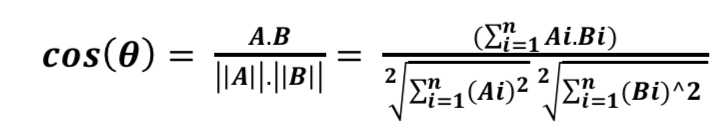

>Source : [Recommender System Application development](https://towardsdatascience.com/recommender-system-application-development-part-1-of-4-cosine-similarity-f6dbcd768e83#:~:text=Similarity%20between%20two%20vectors%20(A,the%20angle%20between%20them%20decreases.))

Now, let's create a new feature that we will use to calculate the similarity between movies, it's a combination of some other features 


In [ ]:
df.info()

In [ ]:
overall_infos = []
for i in range(0, df.shape[0]):
    overall_infos.append(df['type'][i]+' '+df['title'][i]+' '+df['director'][i]+' '+df['cast'][i]+' '+df['description'][i]+' '+df['country'][i])
df['overall_infos'] = overall_infos

when trying to use specific movie we have to use **id**, the one provided with the dataset have a lot of missing ids but at the same time they aren't NaN values, 

let me show you

In [ ]:
df.iloc[4505:4509]

As you can see the id after **s4960** is **s4962** , and there are alot of these mistakes, so i will make my own id column

In [ ]:
df.insert(1, "id", list(range(1, 6659)), True) 

In [ ]:
df.head(1)

Now let's see the features that we will use

In [ ]:
df_new = df[['id','overall_infos']]
df_new.head(1)

## Text Preprocessing 

Before calculating similarity, a text preprocessing is need to be applied on the new feature, to make it easier for the cosine similarity algorithm when deal with each row after transforming them into vectors

In [ ]:
#Stopwords help us to get rid of unwanted words like: a, an, are, is, ...
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
def text_preprocessing(column):
    #make all words with lower letters
    column = column.str.lower()
    #getting rid of any punctution
    column = column.str.replace('http\S+|www.\S+|@|%|:|,|', '', case=False)
    #spliting each sentence to words to apply previous funtions on them 
    word_tokens = column.str.split()
    keywords = word_tokens.apply(lambda x: [item for item in x if item not in stop])
    #assemble words of each sentence again and assign them in new column
    for i in range(len(keywords)):
        keywords[i] = " ".join(keywords[i])
        column = keywords

    return column

In [ ]:
df_new['cleaned_infos'] = text_preprocessing(df_new['overall_infos'])


Now let's see the difference before and after apply **text_preprocessing** function

In [ ]:
df['overall_infos'][6]

In [ ]:
df_new['cleaned_infos'][6]

To apply Cosine similarity we need to transform each sentence into vector, **CountVectorizer** will do this for us and combine them all in one matrix

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

CV = CountVectorizer()
converted_metrix = CV.fit_transform(df_new['cleaned_infos'])

In [ ]:
cosine_similarity = cosine_similarity(converted_metrix)

Let's see what is the matrix looks like

In [ ]:
cosine_similarity

## Testing

Now, let's test it, we will see what recommendations would we get according to any movie or series

In [ ]:
#finding the correct name of a movie
df[df['title'].str.contains('Ninja')]

In [ ]:
#this how we will get the id of the movie so we can check similarity between it and other movies
title = 'Teenage Mutant Ninja Turtles'

movie_id = df[df['title'] == title]['id'].values[0]

In [ ]:
score = list(enumerate(cosine_similarity[movie_id]))

In [ ]:
#now sort the similar movies in descending order
sorted_score = sorted(score, key=lambda x:x[1], reverse= True)
#we will ignore the first score because it will give us a 100% score because it's the same movie 
sorted_score = sorted_score[1:]

In [ ]:
sorted_score[0:10]

In [ ]:
#now showing the top 5 movies similar to TMNT accroding to this algorithm
i = 0
for item in sorted_score:
    movie_title = df[df['id'] == item[0]]['title'].values[0]
    print(i+1,movie_title)
    i = i+1
    if i > 4:
        break

Not a fancy suggestions but it should work according to the dataset we got

## References

>1 - [Recommender System Application development by Emre Havan](https://towardsdatascience.com/recommender-system-application-development-part-1-of-4-cosine-similarity-f6dbcd768e83#:~:text=Similarity%20between%20two%20vectors%20(A,the%20angle%20between%20them%20decreases.))

>2 - [Build A Movie Recommendation Engine Using Python by 'Computer Science' channel on Youtube](https://www.youtube.com/watch?v=ueKXSupHz6Q)


## Upcoming

more visualization and EDA will be added soon to understanfd this dataset more but for now the main purpose of this notebook is to practice the implementation of a recommender system.

Thanks for reaching this section of my notebook, hope you liked it, if so support me with an upvote :)